In [1]:
# Libraries
import pandas as pd
import pathlib
import sys
import numpy as np
from pathlib import Path
import tifffile
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import trackpy as tp
from skimage.measure import find_contours



In [2]:
# Importing rsnaped
current_dir = pathlib.Path().absolute()
rsnaped_dir=current_dir.parents[2].joinpath('rsnaped','rsnaped')
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

Problems importing rsnapsim


In [3]:
# big fish library
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.detection as detection
import bigfish.multistack as multistack

# 3D Random walk

In [4]:
def generate_random_walk(number_frames, weights, num_particles,yx_size=512,z_size=13):
    # Function that generates a random walk
    initial_positions = [np.random.uniform(low=[0, 0, 0], high=[yx_size, yx_size, z_size]) for _ in range(num_particles)]
    positions = np.zeros((num_particles, number_frames, 3))
    for particle in range(num_particles):
        positions[particle, 0] = initial_positions[particle]
        for i in range(1, number_frames):
            #steps = np.random.choice([-1, 0, 1], size=3, p=[0.25, 0.5, 0.25] )
            rand_mov_x = np.random.choice([-1, 0, 1])
            rand_mov_y = np.random.choice([-1, 0, 1])
            rand_mov_z = np.random.choice([-1, 0, 1], p=[0.05, 0.9, 0.05]) # 10% chance of moving in z
            steps = np.array([rand_mov_x, rand_mov_y, rand_mov_z])  
            steps *= weights
            # Ensure positions stay within the specified ranges
            temp = positions[particle, i-1] + steps
            if temp[0] > 0 and temp[1] > 0 and temp[2] > 0 and temp[0] < yx_size and temp[1] < yx_size and temp[2] < z_size:    
                positions[particle, i] = positions[particle, i-1] + steps
            else:
                positions[particle, i] = positions[particle, i-1]   
    return positions

# Function that creates a dataframe from the random walk
def create_dataframe(number_frames, weights, num_particles):
    positions = generate_random_walk(number_frames, weights, num_particles)
    dfs = []
    for particle, pos_array in enumerate(positions):
        df = pd.DataFrame(pos_array, columns=['x', 'y', 'z'])
        df['frame'] = df.index
        df['particle'] = particle
        df = df[['particle', 'frame', 'x', 'y', 'z']]
        dfs.append(df)
    return pd.concat(dfs)


In [5]:
def plot_trajectories(df, plot_type='both', figsize=(12, 6),x_range=None,y_range=None, z_range=None,show_legend=True):
    if 'Cell_ID' in df.columns:
        elements_to_group = ['Cell_ID','particle']
    else:
        elements_to_group = 'particle'
    # function to plot the trajectories
    if plot_type == '3d' or plot_type == 'both':
        fig = plt.figure(figsize=figsize)
        ax3d = fig.add_subplot(121, projection='3d')
        for particle, group in df.groupby(elements_to_group):
            ax3d.plot(group['x'], group['y'], group['z'], label=f'Particle {particle}')
            ax3d.scatter(group['x'].iloc[0], group['y'].iloc[0], group['z'].iloc[0], color='red', marker='s', s=50)  # Square marker at the start
        ax3d.set_xlabel('X')
        ax3d.set_ylabel('Y')
        ax3d.set_zlabel('Z')
        ax3d.set_title('Trajectories of Particles (3D)')
        if not x_range is None:
            ax3d.set_xlim(x_range)
        if not y_range is None:
            ax3d.set_ylim(y_range)
        if not z_range is None:
            ax3d.set_zlim(z_range)    
        if show_legend:
            ax3d.legend()
    if plot_type == '2d' or plot_type == 'both':
        if plot_type == 'both':
            ax2d = fig.add_subplot(122)
        else:
            fig = plt.figure(figsize=figsize)
            ax2d = fig.add_subplot(111)
        for particle, group in df.groupby(elements_to_group):
            ax2d.plot(group['x'], group['y'], label=f'Particle {particle}')
            ax2d.scatter(group['x'].iloc[0], group['y'].iloc[0], color='red', marker='s', s=50)  # Square marker at the start
        ax2d.set_xlabel('X')
        ax2d.set_ylabel('Y')
        ax2d.set_title('Trajectories of Particles (2D)')
        if not x_range is None:
            ax2d.set_xlim(x_range)
        if not y_range is None:
            ax2d.set_ylim(y_range)
        if show_legend:
            ax2d.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def particle_linking(df, search_range=np.linspace(0.5, 2, 4),min_length=10, memory=0, pos_columns=['x', 'y', 'z'], print_results=True):
    # Function that links particles by testing multiple ranges
    #pos_columns = ['xum', 'yum', 'zum']
    list_df = []
    list_detected_trajectories = []
    for i, search_distance in enumerate (search_range):
        try:
            linked = tp.link_df(df, search_distance, pos_columns=pos_columns,memory=memory)
            filtered = tp.filter_stubs(linked, threshold=min_length)
            list_df.append(filtered)
            list_detected_trajectories.append(len(filtered.particle.unique()))
        except:
            list_df.append([])
            list_detected_trajectories.append(0)    
        if print_results:
            print('range: ' ,str(np.round(search_distance,1)), ' number of tracks: ', list_detected_trajectories[i])
    selected_df = list_df[np.argmax(list_detected_trajectories)]
    return selected_df

In [7]:
def particle_linking_separating_cluster_spots(df, search_range=np.linspace(0.5, 2, 4),min_length=10, memory=0, pos_columns=['x', 'y', 'z'], print_results=True):
    # take df and select rows only if column 'cluster' ==0
    df_spots = df[df['cluster_size'] == 0]
    if not df_spots.empty:
        print('Linking spots...')
        df_spots_linked = particle_linking(df_spots, search_range=search_range,min_length=min_length, memory=memory, pos_columns=pos_columns, print_results=print_results)
    else:
        df_spots_linked = pd.DataFrame()
    # take df and select rows only if column 'cluster' ==1
    df_clusters = df[df['cluster_size'] > 0]
    if not df_clusters.empty:
        print('Linking clusters...')
        df_clusters_linked = particle_linking(df_clusters, search_range=search_range,min_length=min_length, memory=memory, pos_columns=pos_columns, print_results=print_results)    
    else:
        df_clusters_linked = pd.DataFrame()  # Create an empty DataFrame if df_clusters is empty
    # Linking the dataframe
    df_linked = pd.concat([df_spots_linked, df_clusters_linked], ignore_index=True)
    return df_linked
    
    

In [8]:
# Example usage for multiple particles with random initial positions
number_frames = 200
weights = [2, 2, 1] # weights for x, y, z movements
num_particles = 10  # Number of particles
random_walk_df = create_dataframe(number_frames, weights, num_particles)
random_walk_df.tail()

,particle,frame,x,y,z
195,9,195,202.397835,445.703754,0.576791
196,9,196,202.397835,443.703754,0.576791
197,9,197,200.397835,443.703754,0.576791
198,9,198,198.397835,443.703754,0.576791
199,9,199,196.397835,443.703754,0.576791


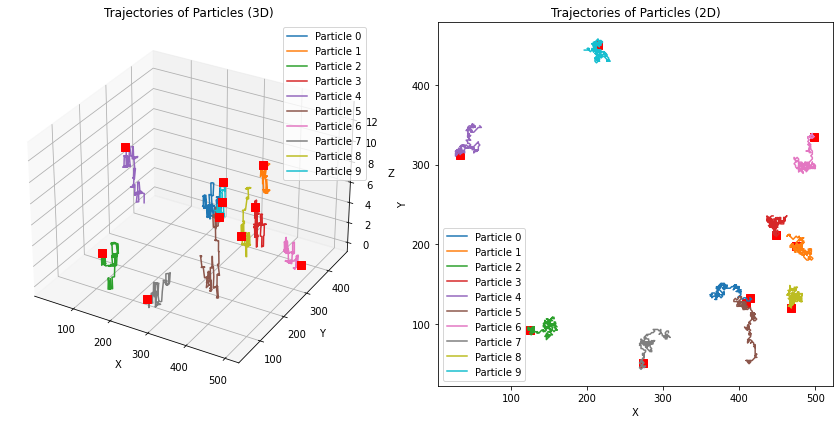

In [9]:
plot_trajectories(random_walk_df, plot_type='both') 

## Testing the linking code with the Random walk

In [10]:
selected_df = particle_linking(df=random_walk_df, search_range=np.linspace(0.5, 20, 5),min_length=100, memory=0, print_results=True)
selected_df

range:  0.5  number of tracks:  0
range:  5.4  number of tracks:  10
range:  10.2  number of tracks:  10
range:  15.1  number of tracks:  10
range:  20.0  number of tracks:  10


,particle,frame,x,y,z
frame,,,,,
0,0,0,414.142267,132.865710,10.123299
0,1,0,408.983297,126.134545,8.780027
0,2,0,33.092828,312.610311,7.888981
0,3,0,474.867085,198.174922,12.781590
0,4,0,468.449062,120.219595,7.780082
...,...,...,...,...,...
199,8,199,150.538633,90.385084,0.008765
199,3,199,466.867085,210.174922,10.781590
199,0,199,370.142267,130.865710,9.123299


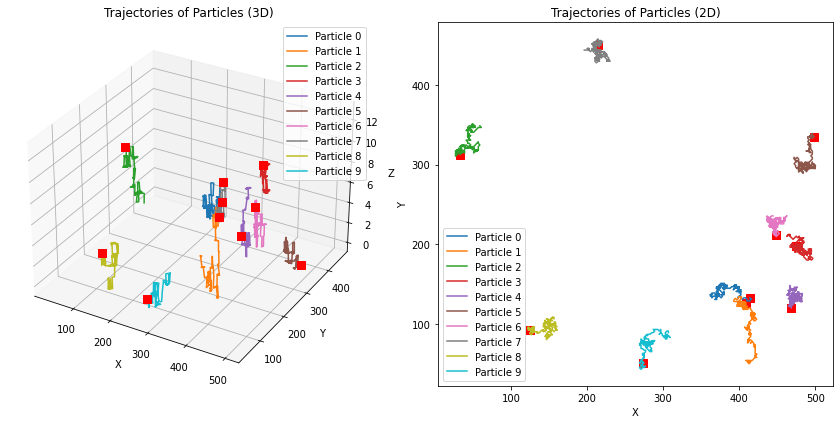

In [11]:
plot_trajectories(selected_df,plot_type='both') 

# Working on real 3d videos.

In [12]:
def spot_detection_3d (rna,threshold_for_spot_detection=None,psf_z=350 ,psf_yx=140,voxel_size_z=500,voxel_size_yx=120,cluster_radius=400,minimum_spots_cluster=3):
    # Calculating Sigma with  the parameters for the PSF.
    spot_radius_px = detection.get_object_radius_pixel(voxel_size_nm=(voxel_size_z,voxel_size_yx, voxel_size_yx), 
                                                    object_radius_nm=(psf_z, psf_yx, psf_yx), ndim=3)
    sigma = spot_radius_px
    ## SPOT DETECTION
    try:
        rna_filtered = stack.log_filter(rna, sigma) # LoG filter
    except ValueError:
        print('Error during the log filter calculation, try using larger parameters values for the psf')
        rna_filtered = stack.remove_background_gaussian(rna, sigma)
    mask = detection.local_maximum_detection(rna_filtered, min_distance=sigma) # local maximum detection        
    if not (threshold_for_spot_detection is None):
        threshold = threshold_for_spot_detection
    else:
        threshold = detection.automated_threshold_setting(rna_filtered, mask) # thresholding
    spots, _ = detection.spots_thresholding(rna_filtered, mask, threshold, remove_duplicate=True)
    spots_post_decomposition, _, _ = detection.decompose_dense(image=rna, 
                                                            spots=spots, 
                                                            voxel_size = (voxel_size_z, voxel_size_yx, voxel_size_yx), 
                                                            spot_radius = (psf_z, psf_yx, psf_yx),
                                                            alpha=0.9,   # alpha impacts the number of spots per candidate region
                                                            beta=1,      # beta impacts the number of candidate regions to decompose
                                                            gamma=5)     # gamma the filtering step to denoise the image
    spots_post_clustering, clusters = detection.detect_clusters(spots_post_decomposition, 
                                                voxel_size=(voxel_size_z, voxel_size_yx, voxel_size_yx),
                                                radius= cluster_radius,
                                                nb_min_spots = minimum_spots_cluster)

    # remove spots that are part of a cluster
    spots_post_clustering = spots_post_clustering[spots_post_clustering[:,-1]==-1 ]
    return spots_post_clustering[:, :3], clusters ,rna_filtered

In [13]:
def spot_detection_3d_frames(video,threshold_for_spot_detection=None,selected_color_channel=0,psf_z=350 ,psf_yx=140,voxel_size_z=500,voxel_size_yx=120,cluster_radius=400,minimum_spots_cluster=3,print_results=True):
    # iterate for all frames
    df = pd.DataFrame() #columns=['frame', 'x', 'y', 'z'])
    num_frames = video.shape[0]
    for i in range (num_frames):
        rna=video[i,:,:,:,selected_color_channel]
        spots, clusters,_ = spot_detection_3d (rna,threshold_for_spot_detection=threshold_for_spot_detection,psf_z=psf_z ,psf_yx=psf_yx,voxel_size_z=voxel_size_z,voxel_size_yx=voxel_size_yx,cluster_radius=cluster_radius,minimum_spots_cluster=minimum_spots_cluster)
        if print_results:
            print('Detected clusters: ',clusters.shape[0],   ', spots: ',spots.shape[0] )
        if spots.shape[0] > 0:
            temp_array_spots =np.zeros((spots.shape[0],5)) # z,y,x,cluster_size
            temp_array_spots[:,0]=i
            temp_array_spots[:,1:-1]=spots
        
        if clusters.shape[0] > 0:
            temp_array_clusters =np.zeros((clusters.shape[0],5)) # z,y,x,cluster_size
            temp_array_clusters[:,0]=i
            temp_array_clusters[:,1:]=clusters[:, :4]
            complete_array = np.vstack((temp_array_spots, temp_array_clusters))
        else:
            complete_array = temp_array_spots
        array_df = pd.DataFrame(complete_array)
    # Append values to the DataFrame
        df = pd.concat([df, array_df], ignore_index=True)
    df = df.rename(columns={0: 'frame', 1: 'z', 2: 'y', 3: 'x', 4: 'cluster_size'})
    # section that converts the coordinates to micrometers
    df['xum'] = df['x'] * voxel_size_yx/1000
    df['yum'] = df['y'] * voxel_size_yx/1000
    df['zum'] = df['z'] * voxel_size_z/1000 
    # removing z axis
    #df = df[['frame', 'y', 'x','cluster_size']].copy()
    return df

In [14]:
def plot_3d_video_detected_spots(image, spots, clusters,cmap='viridis' ):
    # Sample coordinates
    y_spots = spots[:, 1]  # 
    x_spots = spots[:, 2]  # 
    z_spots = spots[:, 0]  # 
    
    x_clusters = clusters[:, 1]
    y_clusters = clusters[:, 2]
    z_clusters = clusters[:, 0]
    # Create a 3D plot and a 2D image plot
    
    fig = plt.figure(figsize=(18, 6))
    # Create the first subplot for 'max_log_filter'
    ax1 = fig.add_subplot(131)
    ax1.imshow(np.max(image, axis=0), cmap=cmap)
    ax1.set_title('max_log_filter', fontsize=16)
    #ax1.grid(True)
    
    
    # Create the second subplot for 'max_log_filter + spots'
    ax2 = plt.subplot(132)
    ax2.imshow(np.max(image, axis=0), cmap=cmap)
    ax2.set_title('max_log_filter + spots', fontsize=16)
    #ax2.grid(True)
    # Plot clusters as circles on top of the 2D image
    radii = clusters[:, 3]*2
    for x, y, r in zip(y_clusters, x_clusters, radii):
        circle = Circle((y, x), r, color='cyan', fill=False)
        ax2.add_patch(circle)
    # Plot circles on top of the 2D image
    radii = len(y_spots) * [3]
    for x, y, r in zip(y_spots, x_spots, radii):
        circle = Circle((y, x), r, color='red', fill=False)
        ax2.add_patch(circle)
    
    
    # Create the third subplot for '3D Spots'
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(x_spots, y_spots, z_spots, c='r', marker='o')
    ax3.scatter(x_clusters, y_clusters, z_clusters, c='b', marker='o')
    ax3.set_xlabel('Y', fontsize=14)
    ax3.set_ylabel('X', fontsize=14)
    ax3.set_zlabel('Z', fontsize=14)
    ax3.set_title('3D Spots', fontsize=16)
    ax3.view_init(elev=20, azim=-5)
    ax3.invert_zaxis()  # Invert z-axis
    ax3.set_xlim(0, image.shape[2])
    ax3.set_ylim(0, image.shape[1])
    ax3.grid(True)
    # Adjust layout
    plt.tight_layout()
    # Show the plot
    plt.show()


In [15]:
def plot_2d_detected_spots(image, spots, clusters):
    plot.plot_detection(np.max(image,axis=0), 
                    spots=[spots[:, :3], clusters[:, :3]], 
                    shape=["circle", "polygon"], 
                    radius=[3, 6], 
                    color=["orangered", "blue"],
                    linewidth=[1, 1], 
                    fill=[False, False], 
                    framesize=(12, 7), 
                    contrast=True,
                    rescale=True,)

In [16]:
def plot_video_frames(video, selected_color_channel=None,cmap='viridis'):
    num_z = video.shape[0]
    num_frames = video.shape[1]
    _, axes = plt.subplots(nrows=num_z, ncols=num_frames, figsize=(15, 10))
    for j in range(num_z):
        for i in range(num_frames):
            if not selected_color_channel is None:
                temp_img = rsp.RemoveExtrema(video[j, i, :, :, selected_color_channel], min_percentile = 0.1, max_percentile = 99.9,format_video='YX').remove_outliers()
                axes[j, i].imshow(temp_img)
            else:
                axes[j, i].imshow(video[j, i, :, :], cmap=cmap)
            axes[j, i].grid(False)
            axes[j, i].set_xticks([])
            axes[j, i].set_yticks([])
            
    plt.tight_layout()
    plt.show()

### Loading video and converting to standard format

In [17]:
video_dir = current_dir.parents[0].joinpath('/home/luisub/Desktop/rsnaped/DataBases/qbio_2022_translation/cell2')
path_files, list_files_paths, list_videos, num_videos = rsp.Utilities.read_files_in_directory(directory=video_dir, extension_of_files_to_look_for = 'tif',return_images_in_list=True)
print('Original video shape: ', list_videos[0].shape) # (z,time, x, y)   # [Z, T, Y, X, C] 
selected_video = list_videos[0]

# Split the second dimension into odd and even indices
even_indices = selected_video[:, ::2, :, :]
odd_indices = selected_video[:, 1::2, :, :]
# Stack them along a new dimension
video = np.stack((even_indices, odd_indices), axis=-1)
print('Transformed video shape: ',video.shape)  # Outputs: (T, Z, Y, X, C)

# Channel 0:  Flag-6X-kdm5b-ms2. translation spots. cytoplasmic RNa should co-localize with Translation. 
# Channel 1:  MCP-GFP- H128 reporter MS2 introns. RNA label only in cytosol. all RNA.


Original video shape:  (10, 28, 512, 512)
Transformed video shape:  (10, 14, 512, 512, 2)


 X-axis contains the z planes 
 Y-axis the time points


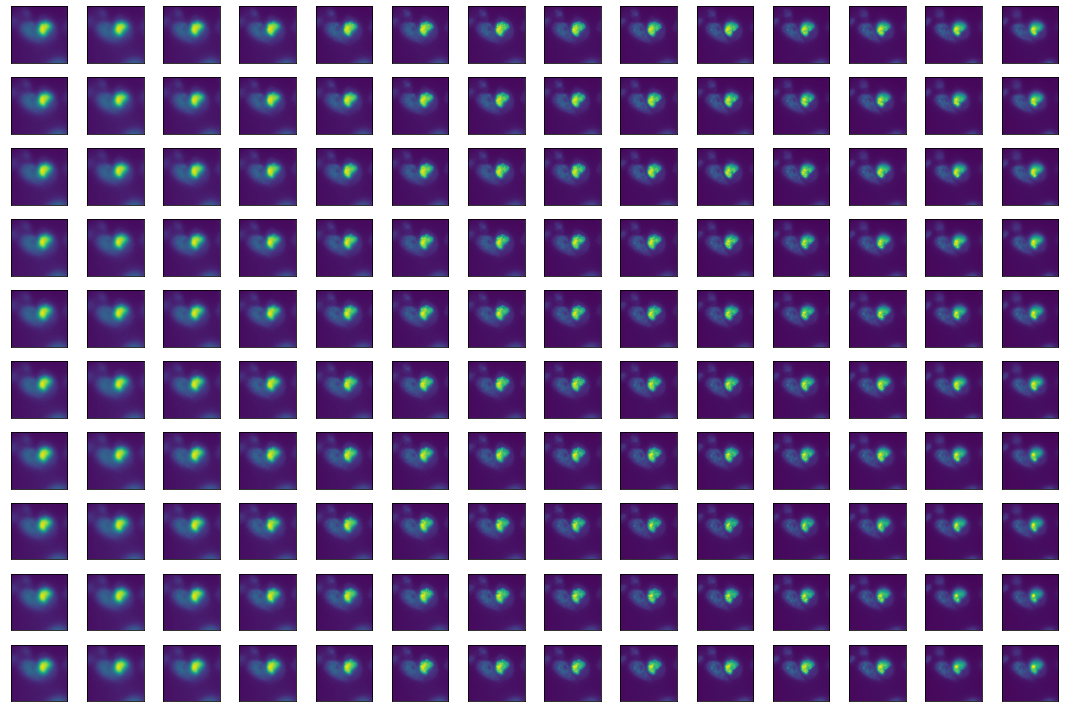

In [18]:
print(' X-axis contains the z planes \n Y-axis the time points')
plot_video_frames(video,selected_color_channel=1) # in this plot the x-axis contains the z planes, and the y-axis the time points


Detected clusters:  0 , spots:  109


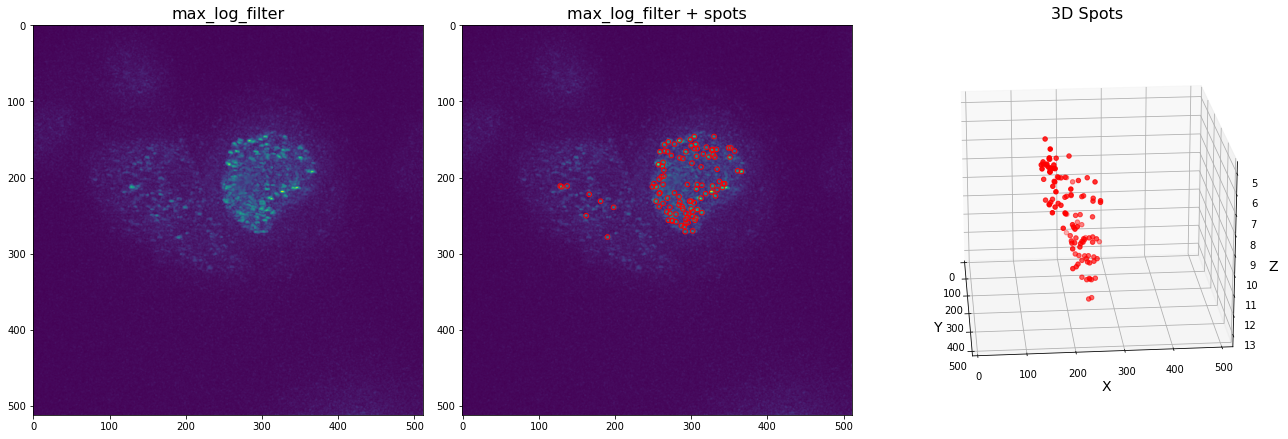

In [19]:
selected_time =0
threshold_for_spot_detection = 2000
video_time_point = video[selected_time,:,:,:,:]
selected_color_channel=1
rna=video_time_point[:,:,:,selected_color_channel]

# Detect spots and clusters
spots, clusters,rna_filtered = spot_detection_3d (rna,threshold_for_spot_detection=threshold_for_spot_detection)
print('Detected clusters: ',clusters.shape[0],   ', spots: ',spots.shape[0] )
#plot_2d_detected_spots(rna_filtered, spots, clusters)
plot_3d_video_detected_spots (image=rna_filtered,spots=spots,clusters=clusters)

In [20]:
# Spot detection in 3D for all frames
df_3d_spots = spot_detection_3d_frames(video,threshold_for_spot_detection=2000,selected_color_channel=1,minimum_spots_cluster=2 )

Detected clusters:  2 , spots:  105
Detected clusters:  3 , spots:  101
Detected clusters:  7 , spots:  92
Detected clusters:  4 , spots:  98
Detected clusters:  8 , spots:  94
Detected clusters:  6 , spots:  93
Detected clusters:  7 , spots:  94
Detected clusters:  3 , spots:  85
Detected clusters:  8 , spots:  95
Detected clusters:  10 , spots:  96


In [21]:
# Spot linking in 3D
linked_df_3d = particle_linking(df=df_3d_spots, search_range=np.linspace(0.5, 5, 4),pos_columns=['x', 'y', 'z'],min_length=5, memory=0, print_results=False)
linked_df_3d.tail()

,frame,z,y,x,cluster_size,xum,yum,zum,particle
frame,,,,,,,,,
9,9,11.0,230.0,264.0,0.0,31.68,27.60,5.5,118
9,9,7.0,248.0,269.0,0.0,32.28,29.76,3.5,206
9,9,8.0,199.0,258.0,0.0,30.96,23.88,4.0,270
9,9,10.0,216.0,129.0,0.0,15.48,25.92,5.0,47
9,9,8.0,215.0,268.0,2.0,32.16,25.80,4.0,357


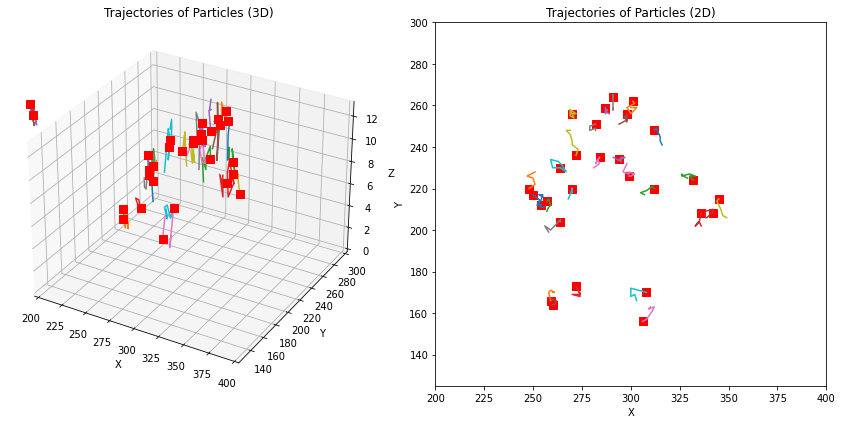

In [22]:
plot_trajectories(linked_df_3d,plot_type='both',show_legend=False,x_range=(200,400),y_range=(125,300), z_range=(0,13)) 

In [23]:
# get the max value in z in linked_df_3d
max_z = linked_df_3d['z'].max()

In [24]:
# Spot linking in 3D
linked_df_3d_separated = particle_linking_separating_cluster_spots(df=df_3d_spots, search_range=np.linspace(0.5, 10, 5),min_length=7, memory=0, pos_columns=['x', 'y', 'z'], print_results=True)

Linking spots...
range:  0.5  number of tracks:  0
range:  2.9  number of tracks:  0
range:  5.2  number of tracks:  8
range:  7.6  number of tracks:  29
range:  10.0  number of tracks:  0
Linking clusters...
range:  0.5  number of tracks:  0
range:  2.9  number of tracks:  0
range:  5.2  number of tracks:  0
range:  7.6  number of tracks:  0
range:  10.0  number of tracks:  0


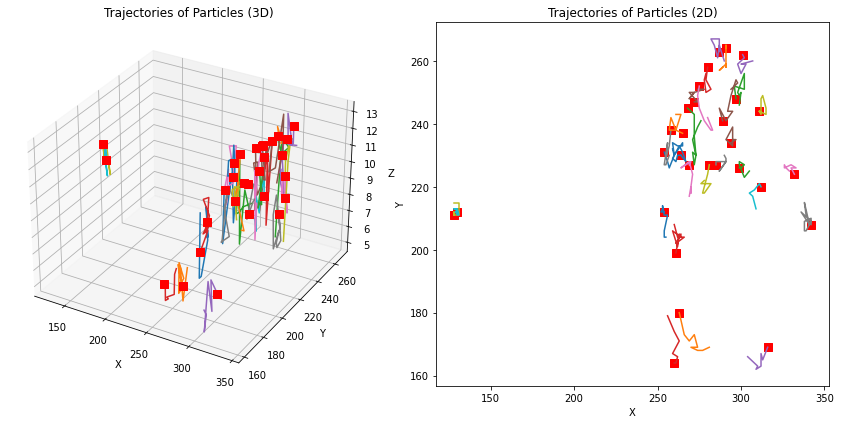

In [25]:
plot_trajectories(linked_df_3d_separated,plot_type='both',show_legend=False) 

In [26]:
video.shape

(10, 14, 512, 512, 2)

# Cell segmentation

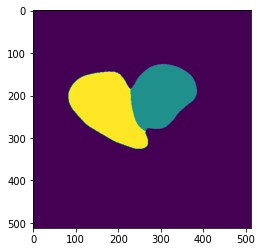

In [27]:
selected_color_channel=1
max_time_projection = np.max(np.max(video, axis=1),axis=0)[:,:,selected_color_channel] # max_in_z, then max_in_time
masks = rsp.Cellpose(video= max_time_projection, num_iterations = 4, channels = [0,0], diameter = 150, model_type = 'cyto', selection_method = 'max_cells_and_area',minimum_cell_area=6000).calculate_masks() # options are 'max_area' or 'max_cells'
plt.imshow(masks)

In [28]:

#Dataframe_trajectories, _, filtered_video = Trackpy(self.video, mask=mask, particle_size = self.particle_size, selected_channel = self.selected_channel_tracking, minimal_frames = minimal_frames, optimization_iterations = self.NUM_ITERATIONS_TRACKING, use_default_filter = use_default_filter, show_plot = self.show_plot,intensity_threshold_tracking=self.intensity_threshold_tracking, image_name=image_name_tracking).perform_tracking()


In [29]:
def plot_trajectories_and_mask(df, masks=None, image=None, plot_type='both', figsize=(20, 6),x_range=None,y_range=None, z_range=None,show_legend=True,z_view=None):
    if 'Cell_ID' in df.columns:
        elements_to_group = ['Cell_ID','particle']
    else:
        elements_to_group = 'particle'
    max_z = df['z'].max().astype(int)
    # function to plot the trajectories
    if plot_type == '3d' or plot_type == 'both':
        fig = plt.figure(figsize=figsize)
        ax3d = fig.add_subplot(131, projection='3d')
        if not masks is None:
            number_masks = np.max(masks)
            if number_masks > 0:
                for index_mask in range(1, number_masks + 1):
                    mask_selected = np.where(masks == index_mask, 1, 0)
                    binary_mask = np.where(masks == index_mask, 1, 0)
                    # Find contours in the binary mask
                    contours = find_contours(binary_mask, 0.5)
                    # Extract the largest contour
                    largest_contour = max(contours, key=len)
                    # Downsample the contour
                    downsample_factor = 20  # Adjust this factor as needed
                    downsampled_contour = largest_contour[::downsample_factor]
                    # Swap columns to rows
                    downsampled_contour[:, [0, 1]] = downsampled_contour[:, [1, 0]]
                    # Repeat the 2D polygon in the z-direction
                    num_z_layers = max_z
                    z_values = np.linspace(0, num_z_layers, num_z_layers)  # Adjust as needed for the z-spacing
                    vertices_3d = np.zeros((len(downsampled_contour) * num_z_layers, 3))
                    for i, z in enumerate(z_values):
                        vertices_3d[i * len(downsampled_contour):(i + 1) * len(downsampled_contour), :2] = downsampled_contour
                        vertices_3d[i * len(downsampled_contour):(i + 1) * len(downsampled_contour), 2] = z
                    # Connect the vertices to form faces
                    faces = []
                    for i in range(num_z_layers - 1):
                        for j in range(len(downsampled_contour)):
                            a = i * len(downsampled_contour) + j
                            b = i * len(downsampled_contour) + (j + 1) % len(downsampled_contour)
                            c = (i + 1) * len(downsampled_contour) + (j + 1) % len(downsampled_contour)
                            d = (i + 1) * len(downsampled_contour) + j
                            faces.append([a, b, c, d])

                    # Plot vertices
                    #ax.scatter(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2])

                    # Plot XY connections with one color
                    for i in range(num_z_layers):
                        for j in range(len(downsampled_contour) - 1):
                            x = vertices_3d[i * len(downsampled_contour) + j:i * len(downsampled_contour) + j + 2, 0]
                            y = vertices_3d[i * len(downsampled_contour) + j:i * len(downsampled_contour) + j + 2, 1]
                            z = vertices_3d[i * len(downsampled_contour) + j:i * len(downsampled_contour) + j + 2, 2]
                            ax3d.plot(x, y, z, color='b', linewidth=0.5, linestyle='--')

                    # Plot Z connections with another color
                    for i in range(num_z_layers - 1):
                        for j in range(len(downsampled_contour)):
                            x = vertices_3d[i * len(downsampled_contour) + j, 0], vertices_3d[(i + 1) * len(downsampled_contour) + j, 0]
                            y = vertices_3d[i * len(downsampled_contour) + j, 1], vertices_3d[(i + 1) * len(downsampled_contour) + j, 1]
                            z = vertices_3d[i * len(downsampled_contour) + j, 2], vertices_3d[(i + 1) * len(downsampled_contour) + j, 2]
                            ax3d.plot(x, y, z, color='k', linewidth=0.2, linestyle='--')
        if not z_view is None:
            ax3d.view_init(elev=z_view[0], azim=z_view[1])
        else:
            ax3d.view_init(elev=40, azim=80) # Adjust the elevation and azimuth angles as needed

        # Plotting trajectories of particles in 3D
        for particle, group in df.groupby(elements_to_group):
            ax3d.plot(group['x'], group['y'], group['z'], label=f'Particle {particle}', linewidth=1, linestyle='-')
            ax3d.scatter(group['x'].iloc[0], group['y'].iloc[0], group['z'].iloc[0], color='b', marker='s', s=10,alpha=0.5)  # Square marker at the start
        ax3d.set_xlabel('X')
        ax3d.set_ylabel('Y')
        ax3d.set_zlabel('Z')
        ax3d.set_title('Trajectories of Particles (3D)')
        if not x_range is None:
            ax3d.set_xlim(x_range)
        if not y_range is None:
            ax3d.set_ylim(y_range)
        if not z_range is None:
            ax3d.set_zlim(z_range)    
        if show_legend:
            ax3d.legend()
        ax3d.invert_yaxis()
    # Plotting trajectories of particles in 2D
    if plot_type == '2d' or plot_type == 'both':
        if plot_type == 'both':
            ax2d = fig.add_subplot(132)
        else:
            fig = plt.figure(figsize=figsize)
            ax2d = fig.add_subplot(111)
        
        if not masks is None:
            number_masks = np.max(masks)
            if number_masks > 0:
                for index_mask in range(1, number_masks + 1):
                    mask_selected = np.where(masks == index_mask, 1, 0)
                    binary_mask = np.where(masks == index_mask, 1, 0)
                    # Find contours in the binary mask
                    contours = find_contours(binary_mask, 0.5)
                    # Extract the largest contour
                    largest_contour = max(contours, key=len)
                    # Downsample the contour
                    downsample_factor = 1  # Adjust this factor as needed
                    downsampled_contour = largest_contour[::downsample_factor]
                    # swaping columns to rows
                    ax2d.plot(downsampled_contour[:, 1], downsampled_contour[:, 0], color='k', linewidth=2, linestyle='-')
        # Plotting particles
        for particle, group in df.groupby(elements_to_group):
            ax2d.plot(group['x'], group['y'], label=f'Particle {particle}')
            ax2d.scatter(group['x'].iloc[0], group['y'].iloc[0], color='b', marker='s', s=10,alpha=0.5)  # Square marker at the start
        ax2d.set_xlabel('X')
        ax2d.set_ylabel('Y')
        ax2d.set_title('Trajectories of Particles (2D)')
        if not x_range is None:
            ax2d.set_xlim(x_range)
        if not y_range is None:
            ax2d.set_ylim(y_range)
        if show_legend:
            ax2d.legend()
        ax2d.invert_yaxis()
        ax2d.set_aspect('equal')
    
    # Ploting the original image
    if plot_type == 'both':
        ax_img = fig.add_subplot(133)
    else:
        fig = plt.figure(figsize=figsize)
        ax_img = fig.add_subplot(111)
    ax_img.imshow(np.max(image, axis=0), cmap='viridis')
    ax_img.set_title('Filtered image (selected z-slice and time point)')
    
    plt.tight_layout()
    plt.show()

In [30]:
def spots_in_mask(df,mask):
    # extracting the contours in the image
    coords = np.array([df.y, df.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
    df['In Mask'] = values_at_coords # Check if pts are on/in polygon mask  
    return df 

In [31]:
number_masks = np.max(masks)
if number_masks>0:
    list_df = []
    for index_mask in range(1,number_masks+1):
        mask_selected = np.where(masks == index_mask,1,0 )
        # Adding a column indicating if the spots are located inside the mask 
        dataframe_with_label_in_mask = spots_in_mask(df_3d_spots,mask_selected)
        # Selecting only the spots located inside the mask
        dataframe_particles_in_mask = dataframe_with_label_in_mask[dataframe_with_label_in_mask['In Mask']==True]
        linked_df_3d_separated_in_mask = particle_linking_separating_cluster_spots(df=dataframe_particles_in_mask, search_range=np.linspace(0.5, 10, 5),min_length=7, memory=0, pos_columns=['x', 'y', 'z'], print_results=True)
        column_cell_id = np.ones(linked_df_3d_separated_in_mask.shape[0])*(index_mask-1)
        # add column with the cell id
        linked_df_3d_separated_in_mask['Cell_ID'] = column_cell_id
        list_df.append(linked_df_3d_separated_in_mask)
    # Concatenate the dataframes
    df_concat = pd.concat(list_df)
    # making 'Cell_Id' an integer
    df_concat['Cell_ID'] = df_concat['Cell_ID'].astype(int)
else:
    df_concat = pd.DataFrame()  # Create an empty DataFrame if no masks are detected 
        

Linking spots...
range:  0.5  number of tracks:  0
range:  2.9  number of tracks:  0
range:  5.2  number of tracks:  6
range:  7.6  number of tracks:  27
range:  10.0  number of tracks:  0
Linking clusters...
range:  0.5  number of tracks:  0
range:  2.9  number of tracks:  0
range:  5.2  number of tracks:  0
range:  7.6  number of tracks:  0
range:  10.0  number of tracks:  0
Linking spots...
range:  0.5  number of tracks:  0
range:  2.9  number of tracks:  0
range:  5.2  number of tracks:  2
range:  7.6  number of tracks:  2
range:  10.0  number of tracks:  2
Linking clusters...
range:  0.5  number of tracks:  0
range:  2.9  number of tracks:  0
range:  5.2  number of tracks:  0
range:  7.6  number of tracks:  0
range:  10.0  number of tracks:  0


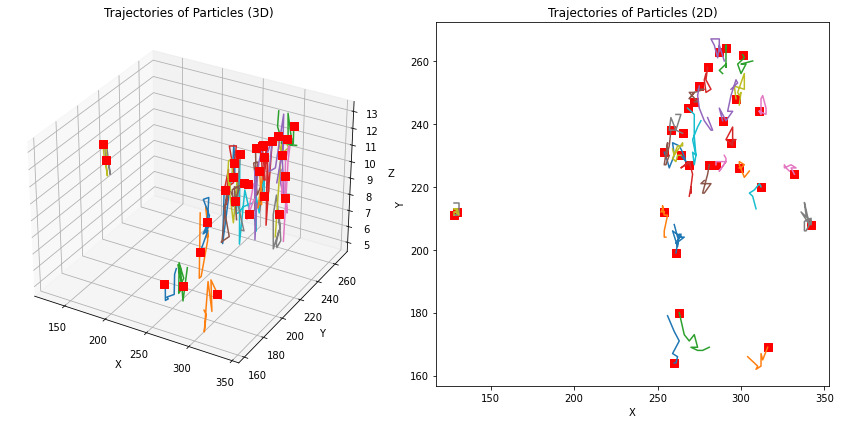

In [32]:
# Plotting the trajectories
plot_trajectories(df_concat,plot_type='both',show_legend=False)

In [33]:
df_concat

,frame,z,y,x,cluster_size,xum,yum,zum,In Mask,particle,Cell_ID
0,0,9.0,231.0,254.0,0.0,30.48,27.72,4.5,1,1,0
1,0,8.0,212.0,254.0,0.0,30.48,25.44,4.0,1,7,0
2,0,6.0,180.0,263.0,0.0,31.56,21.60,3.0,1,8,0
3,0,11.0,258.0,280.0,0.0,33.60,30.96,5.5,1,26,0
4,0,10.0,263.0,287.0,0.0,34.44,31.56,5.0,1,30,0
...,...,...,...,...,...,...,...,...,...,...,...
10,5,10.0,213.0,130.0,0.0,15.60,25.56,5.0,1,7,1
11,5,9.0,215.0,131.0,0.0,15.72,25.80,4.5,1,6,1
12,6,11.0,211.0,131.0,0.0,15.72,25.32,5.5,1,7,1
13,6,10.0,215.0,128.0,0.0,15.36,25.80,5.0,1,6,1


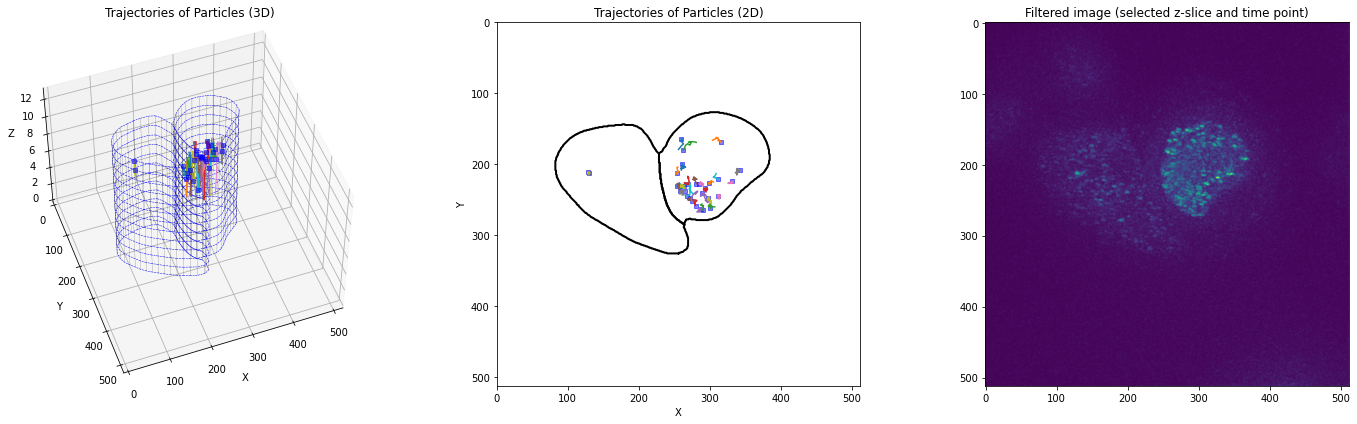

In [34]:
plot_trajectories_and_mask(df_concat,image=rna_filtered, masks=masks,plot_type='both',show_legend=False,x_range=(0,512),y_range=(0,512), z_range=(0,13),z_view=(50,70)) # z_view =(elevations, azimuth_angle)

In [35]:
#dataframe_particles_in_mask

In [36]:
#linked_df_3d_separated_in_mask = particle_linking_separating_cluster_spots(df=dataframe_particles_in_mask, search_range=np.linspace(0.5, 10, 5),min_length=7, memory=0, pos_columns=['x', 'y', 'z'], print_results=True)

In [37]:
#plot_trajectories(linked_df_3d_separated_in_mask,plot_type='both',show_legend=False) 